# **Column Descriptions**

- `PassengerId` - уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp — его номер в группе. Люди в группе часто являются членами семьи, но не всегда.
- `HomePlanet` - планета, с которой вылетел пассажир, обычно планета его постоянного проживания.
- `CryoSleep` – указывает, выбрал ли пассажир режим анабиоза на время путешествия. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.
- `Cabin` - Номер каюты, в которой находится пассажир. Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, либо S для правого борта.
- `Пункт назначения` - планета, на которую будет высаживаться пассажир.
- `Возраст` - Возраст пассажира.
- `VIP` - оплатил ли пассажир специальное VIP-обслуживание во время рейса.
- `RoomService`, FoodCourt, ShoppingMall, Spa, VRDeck - Сумма, которую пассажир выставил в счет за каждое из многочисленных роскошных удобств космического корабля Титаник.
- `Name` - Имя и фамилия пассажира.
- `Транспортировано` - Был ли пассажир перенесен в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.

# 1. **Import libraries**

In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 2. **EDA**

In [3]:
train=pd.read_csv('/spaceship-titanic/train.csv')
test=pd.read_csv('/spaceship-titanic/test.csv')

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


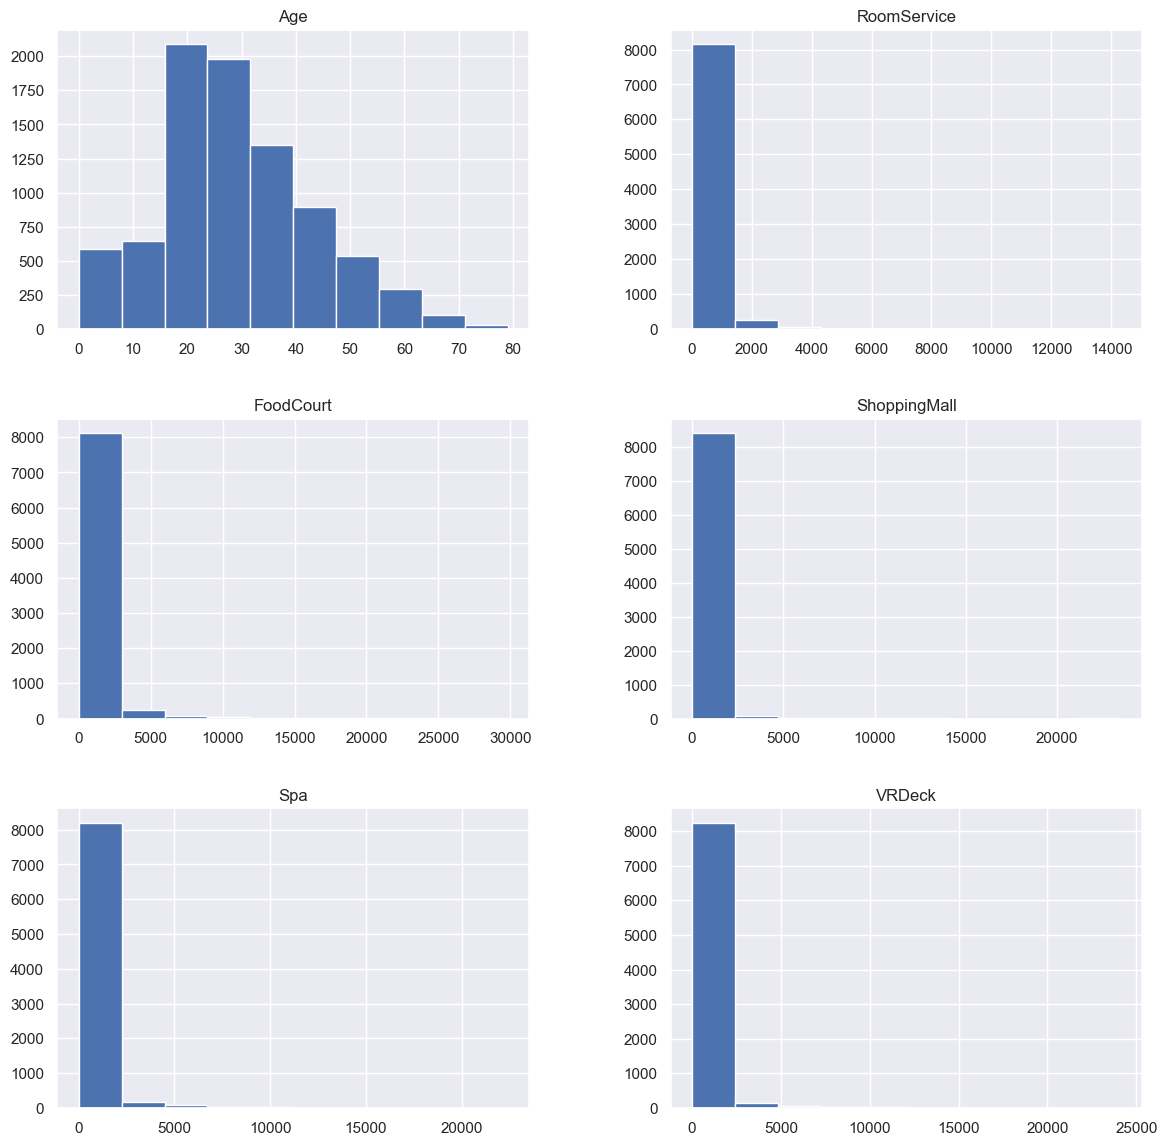

In [7]:
sns.set()

train.hist(figsize=(14,14));

<AxesSubplot: >

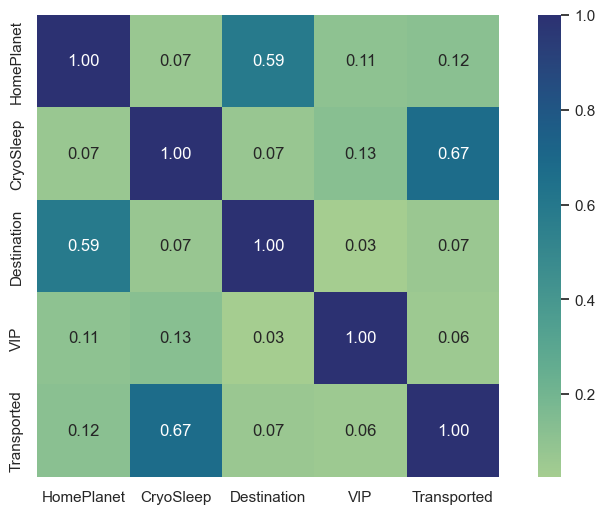

In [8]:
plt.subplots(figsize=(10, 6))
sns.heatmap(
    train[['HomePlanet', 'CryoSleep', 'Destination',
           'VIP', 'Transported']].phik_matrix(),
    cmap="crest",
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
)

Phik корреляция показывает некую зависимость между CryoSleep и целевым признаком Transported. 

<AxesSubplot: >

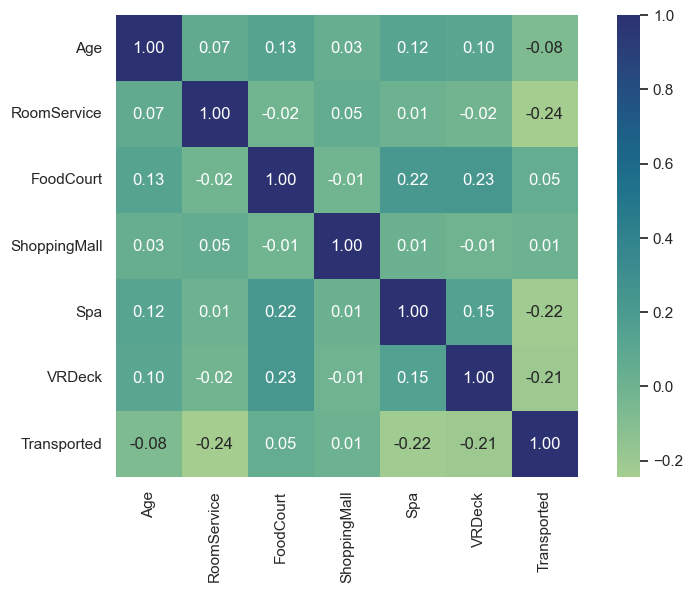

In [9]:
plt.subplots(figsize=(10, 6))
sns.heatmap(
    train.corr(method='pearson'),
    cmap="crest",
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
)

В числовых признаках никаких зависимостей не обнаружено.

Посмотрим на соотношение классов.

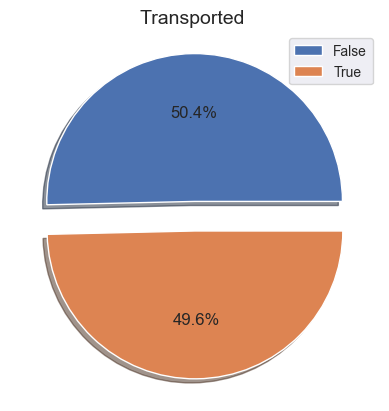

In [10]:
plt.pie(
    train.Transported.value_counts(),
    shadow=True,
    explode=[.1, .1],
    autopct='%.1f%%'
)

plt.title('Transported ', size=14)
plt.legend(['False', 'True'], fontsize=10)
plt.show()

*Вывод:*

Класссы в нашей обучающей выборке оказались сбалансированны, что очень хорошо.

Посмотрим на соотношение пассажиров в категориальных признаках.

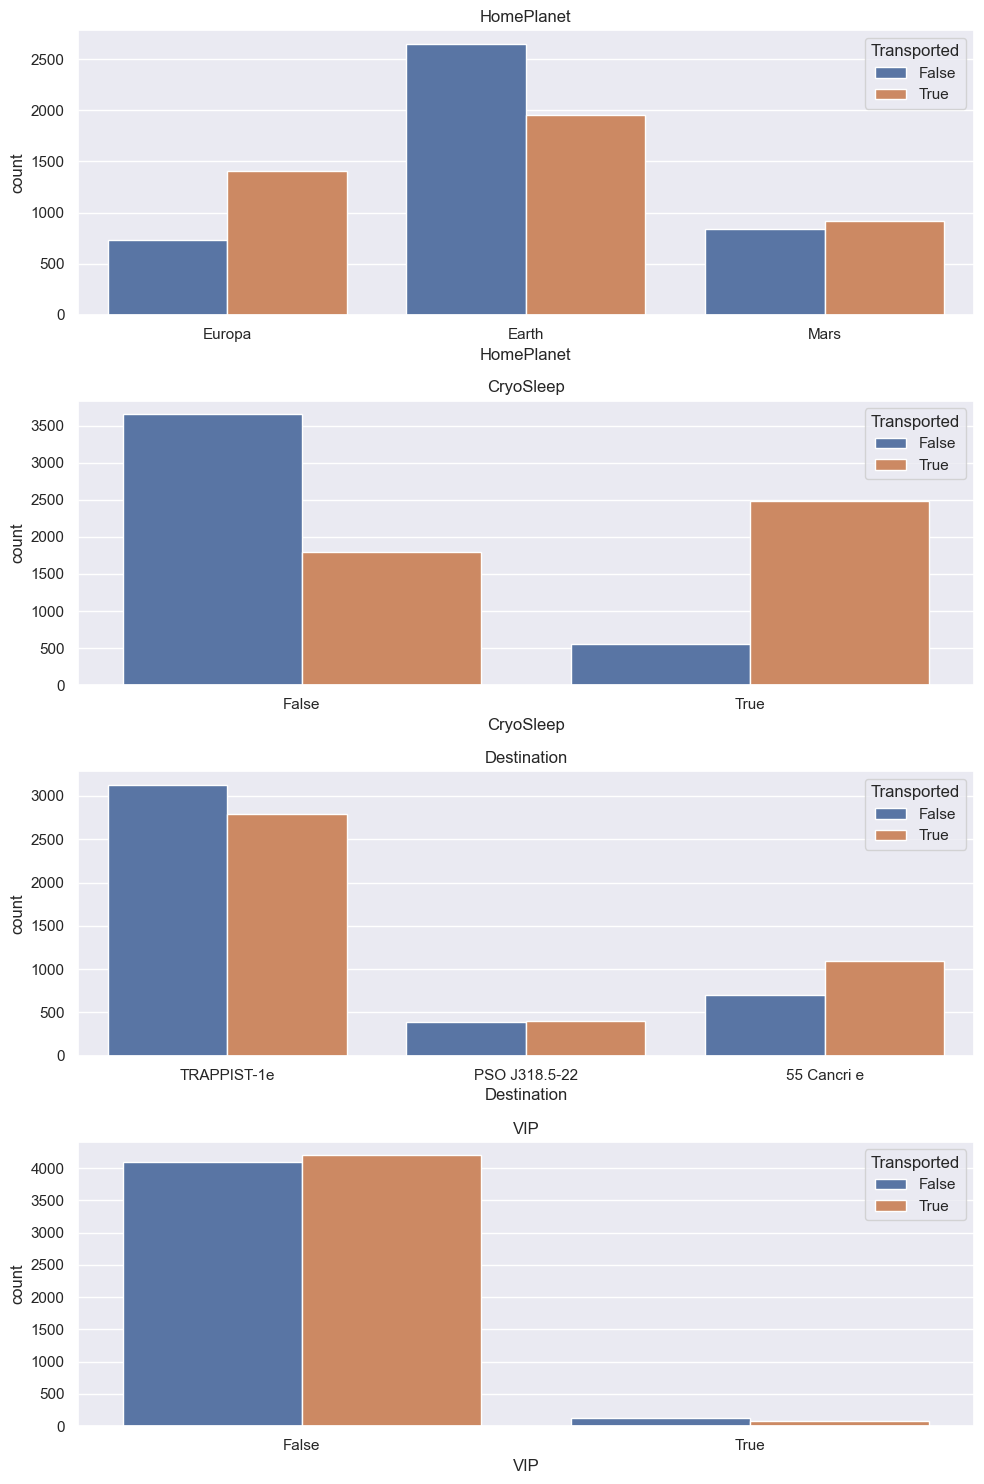

In [11]:
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize=(10, 15))

for i, feat_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i+1)

    sns.countplot(
        data=train,
        x=feat_name,
        axes=ax,
        hue='Transported'
    )

    ax.set_title(feat_name)
fig.tight_layout()
plt.show()

*Вывод:*

* Большинство пассажиров "CryoSleep" перенеслись;
* Признак "VIP" кажется не очень важным ввиду баланса в соотношении.

Теперь взглянем на численные признаки.

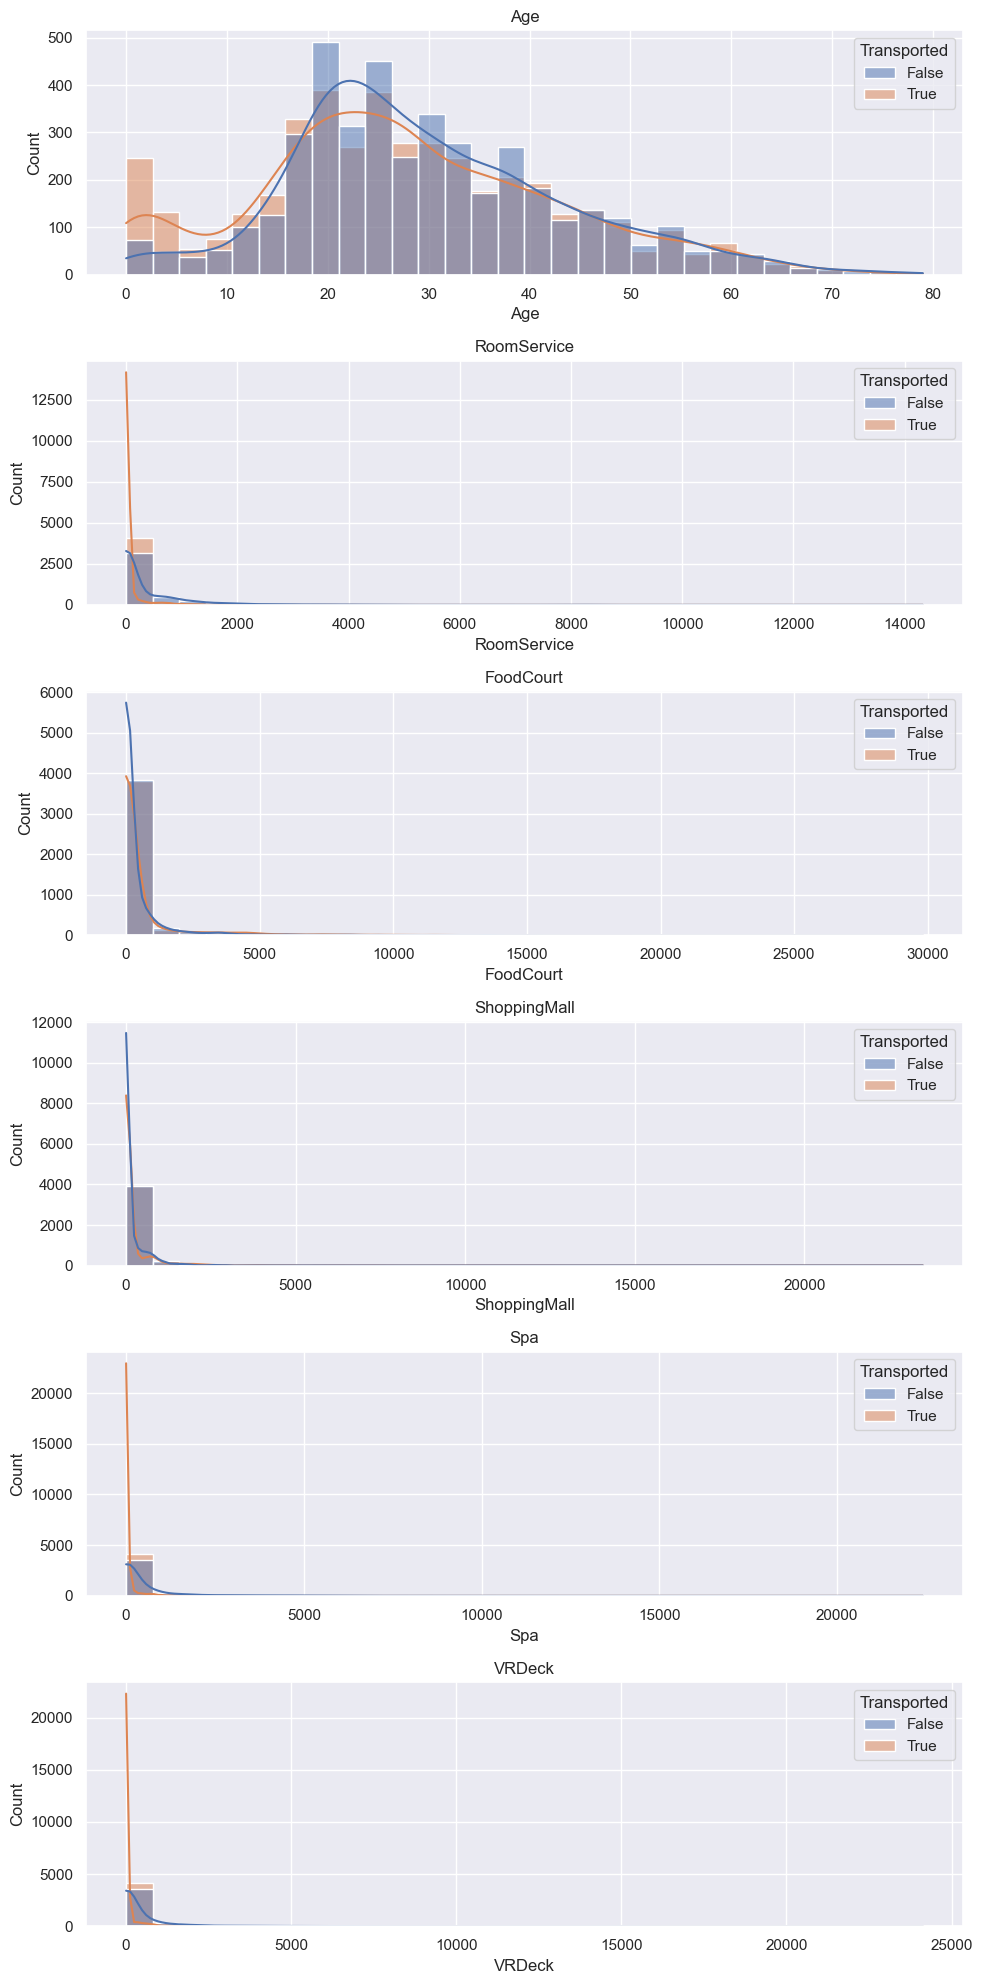

In [12]:
feats = ['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize=(10, 20))

for i, feat_name in enumerate(feats):
    ax = fig.add_subplot(6, 1, 1*i+1)

    sns.histplot(
        data=train,
        x=feat_name,
        axes=ax,
        bins=30,
        hue='Transported',
        kde = True
    )

    ax.set_title(feat_name)
fig.tight_layout()
plt.show()

*Выводы:*
* Люди в возрасте 0-17 лет перенеслись в другое измерение (Tranported True);
* Люди в возрасте 18-40 лет не перенеслись в другое измерение (Tranported True);
* Люди старше 40 лет распределены примерно одинаково;
* Можно создать новый признак, разбивающий пассажиров по возрасту на 3 класса;


* Большинство пассажиров не тратили деньги на различные удобства;
* Можно создать новый бинарный признак, где 0 - люди которые не тратили денег вообще.

Посмотрим на наличие пропусков в данных.

In [13]:
train.isnull().sum().sort_values(ascending = False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Напишем функцию и визауализируем пропуски.

In [14]:
def percent_missing(df):
    missing_num = df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing_data = pd.concat([missing_num,missing_perc],keys=['Total','Percentage'],axis=1)
    missing_data = missing_data[missing_data['Percentage']>0]
       
    return missing_data

In [15]:
percent_missing(train)

,Total,Percentage
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


In [16]:
percent_missing(test)

,Total,Percentage
FoodCourt,106,2.478373
Spa,101,2.361468
Cabin,100,2.338087
ShoppingMall,98,2.291326
Name,94,2.197802
CryoSleep,93,2.174421
VIP,93,2.174421
Destination,92,2.151040
Age,91,2.127660
HomePlanet,87,2.034136


Text(0.5, 1.0, 'Percent missing data by feature on test data')

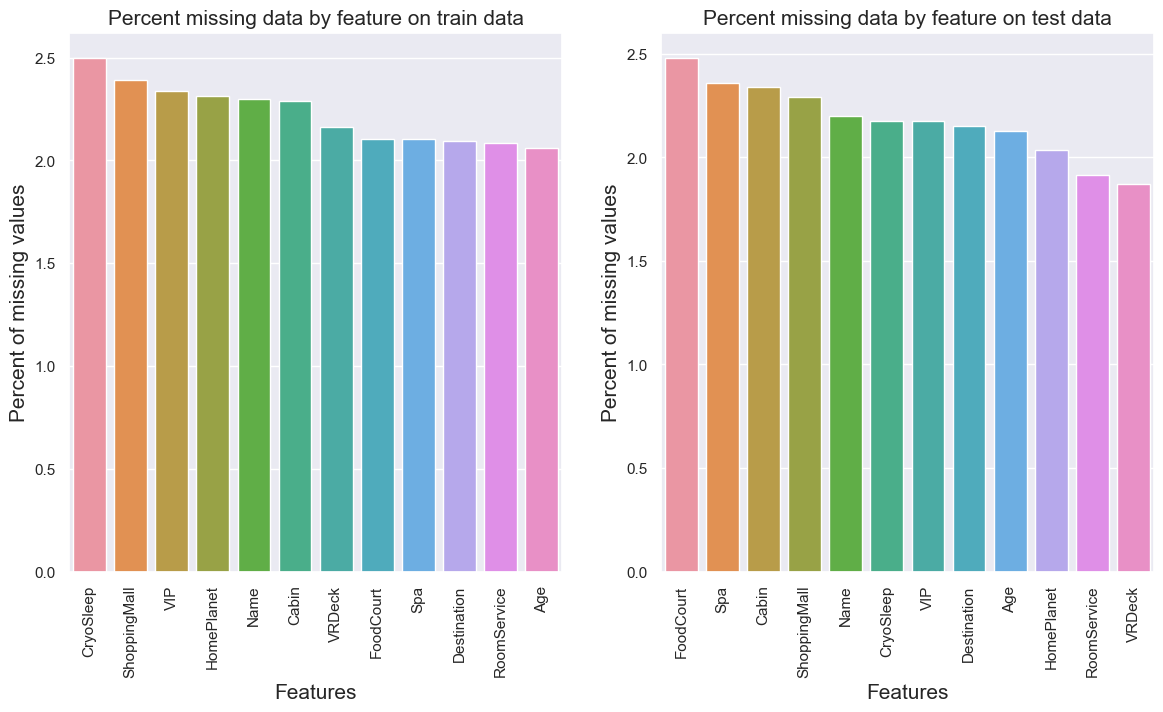

In [17]:
f, ax = plt.subplots(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.barplot(
    x=percent_missing(train).index,
    y=percent_missing(train).Percentage
)

plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature on train data', fontsize=15)

plt.subplot(1, 2, 2)
sns.barplot(
    x=percent_missing(test).index,
    y=percent_missing(test).Percentage
)

plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature on test data', fontsize=15)

In [18]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [19]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


# **3. Feature engineering**

При анализе данных мы не рассмотрели еще 2 категориальных признака: `PassengerId` и `Cabin`.

Разобьем пассажиров на группы и подсчитаем их количество в каждой группе.

In [20]:
#Соединим тестовую и обучающую выборки.
train['istest'] = 0
test['istest'] = 1

raw = pd.concat((train, test)).reset_index(drop=True)

In [21]:
raw

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,istest
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,1
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,1
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,1
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,1


In [28]:
raw['Group'] = raw.PassengerId.apply(lambda x: x.split('_')[0]).astype(int)
raw['Group_size']=raw['Group'].map(lambda x: raw['Group'].value_counts()[x])

In [29]:
raw.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,istest,Group,Group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0,2,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0,3,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0,3,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0,4,1


Оценим влияние группы на выживаемость

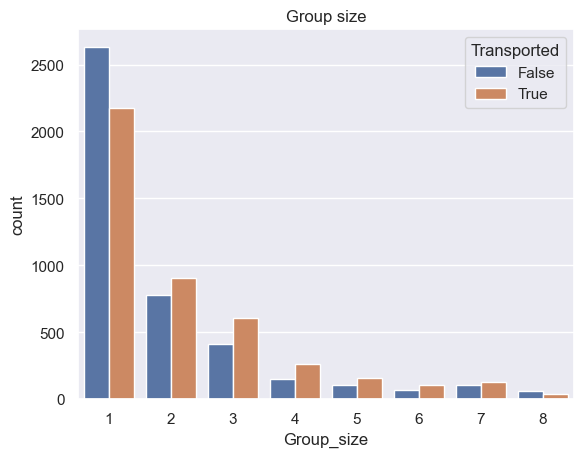

In [30]:
sns.countplot(data=raw, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

Люди в группах скорее переносились. 

Создадим еще одну группу, которая показывает путешествовал ли человек в одиночку.

In [31]:
raw['Solo']=(raw['Group_size']==1).astype(int)

Text(0.5, 1.0, 'Passenger travelling solo or not')

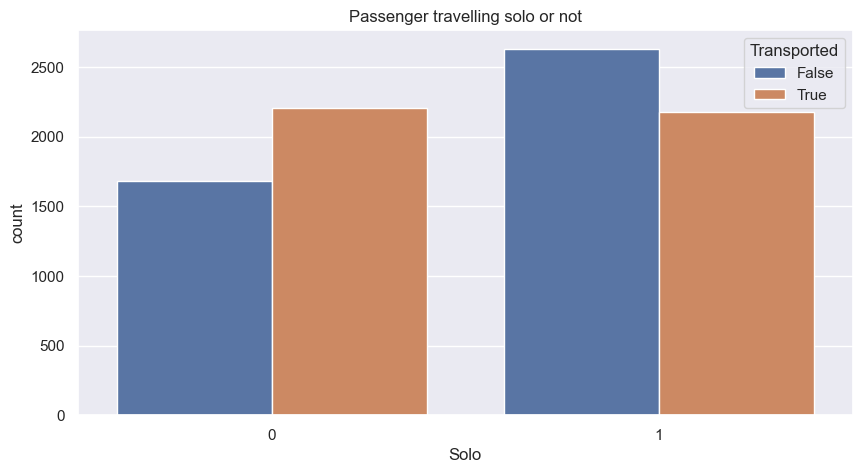

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(data=raw, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')

Теперь посмотрим на признак `Cabin`.

In [33]:
# Заменим значения NaN, инчае мы не сможем выполнить сплит.
raw['Cabin'].fillna('NaN/NaN/NaN', inplace=True)

In [34]:
raw['Deck'] = raw.Cabin.apply(lambda x: x.split('/')[0])
raw['Cabin_number'] = raw.Cabin.apply(lambda x: x.split('/')[1])
raw['Cabin_side'] = raw.Cabin.apply(lambda x: x.split('/')[2])

In [35]:
raw

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,istest,Group,Group_size,Solo,Deck,Cabin_number,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0,1,1,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,0,2,1,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0,3,2,0,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0,3,2,0,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,0,4,1,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,...,0.0,Jeron Peter,NaN,1,9266,2,0,G,1496,S
12966,9269_01,Earth,False,NaN/NaN/NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,...,144.0,Matty Scheron,NaN,1,9269,1,1,NaN,NaN,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,...,0.0,Jayrin Pore,NaN,1,9271,1,1,D,296,P
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,...,523.0,Kitakan Conale,NaN,1,9273,1,1,D,297,P


In [36]:
raw[['Deck', "Cabin_number", "Cabin_side", "Transported"]]

,Deck,Cabin_number,Cabin_side,Transported
0,B,0,P,False
1,F,0,S,True
2,A,0,S,False
3,A,0,S,False
4,F,1,S,True
...,...,...,...,...
12965,G,1496,S,NaN
12966,NaN,NaN,NaN,NaN
12967,D,296,P,NaN
12968,D,297,P,NaN


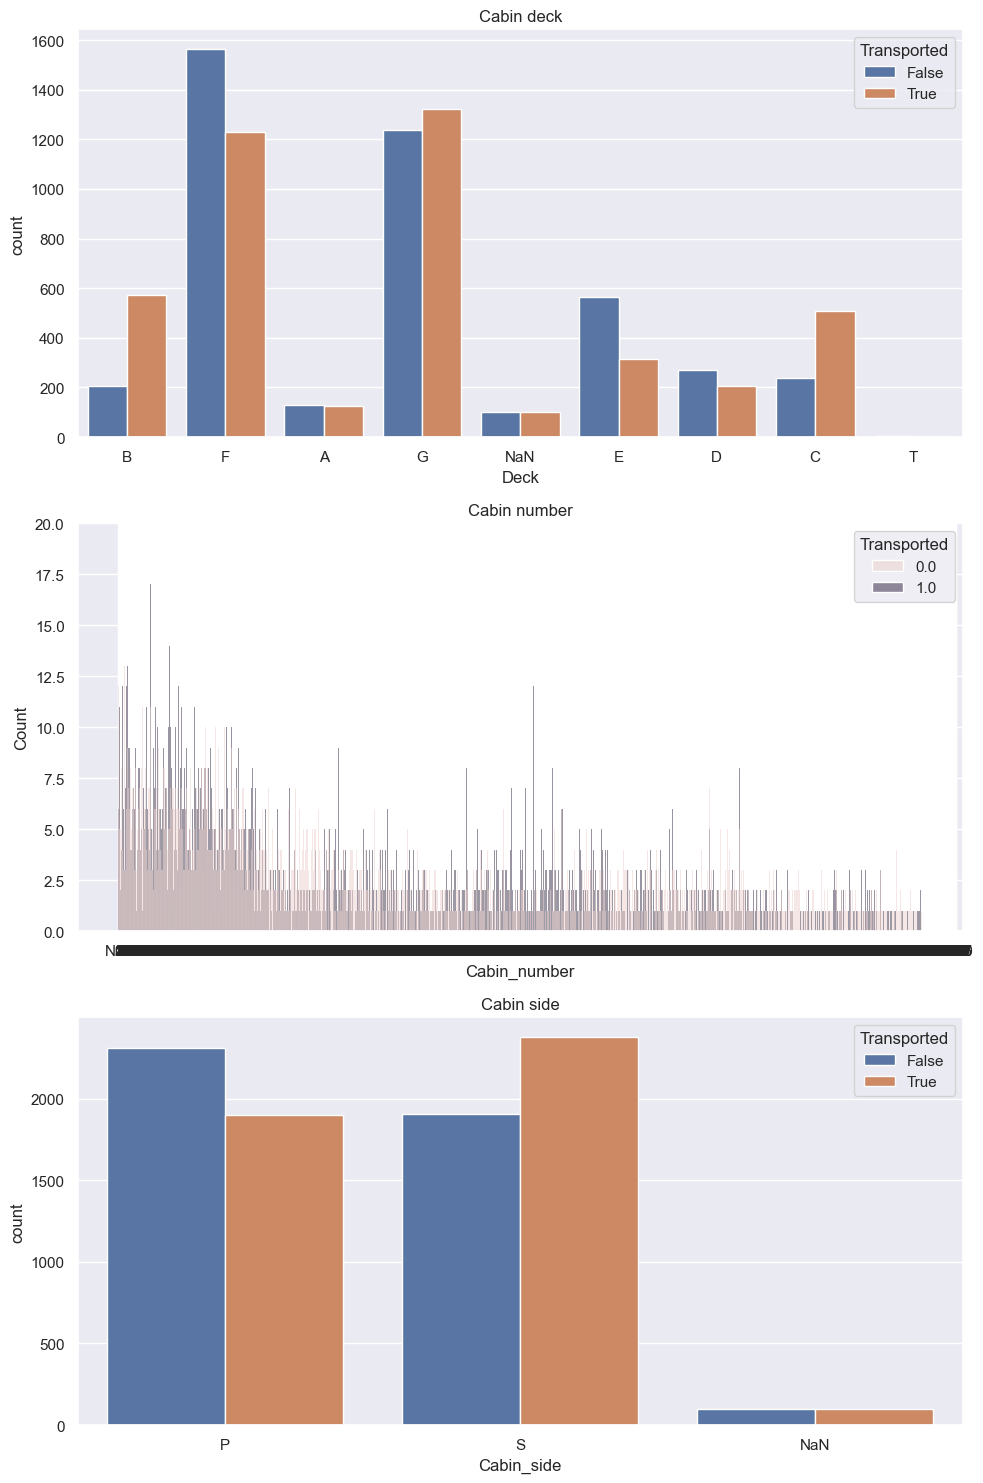

In [37]:
fig=plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
sns.countplot(
    data=raw,
    x='Deck',
    hue='Transported')
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(
    data=raw,
    x='Cabin_number',
    hue='Transported'
    ,binwidth=20)
plt.ylim([0, 20])
plt.title('Cabin number')

plt.subplot(3,1,3)
sns.countplot(
    data=raw,
    x='Cabin_side',
    hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

Теперь создадим признак отвечающий за дополнительные расходы.

In [38]:
raw['Total_Expenditure'] = raw[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

raw['No_spending'] = (raw['Total_Expenditure'] == 0).astype(int)

Text(0.5, 1.0, 'No_spending')

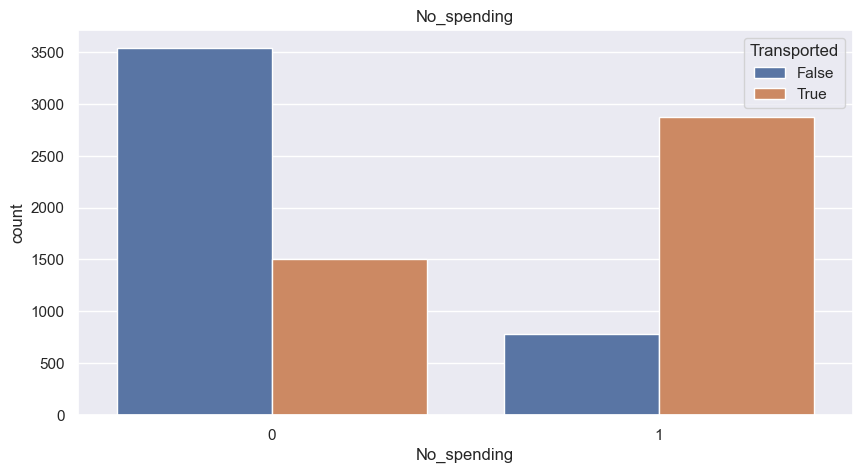

In [39]:
fig = plt.figure(figsize=(10, 5))

sns.countplot(
    data=raw,
    x='No_spending',
    hue='Transported')
plt.title('No_spending')

## **Filling in Missing Values**

Заполним признак `HomePlanet`. Так как в задаче сказано что это планета с которой вылетел пассажир, предположим что люди из одной группы вылетели вместе.

In [40]:
group = raw.groupby(['Group', 'HomePlanet'])['HomePlanet'] \
    .count().unstack().fillna(0)
group

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
...,...,...,...
9276,0.0,1.0,0.0
9277,1.0,0.0,0.0
9278,1.0,0.0,0.0


In [41]:
miss_val_bef = raw['HomePlanet'].isna().sum()
miss_val_bef

288

In [42]:
group_index = raw[raw['HomePlanet'].isna()][(raw[raw['HomePlanet'].isna()]['Group'])
                                            .isin(group.index)].index

In [43]:
raw.loc[group_index, 'HomePlanet'] = raw.iloc[group_index, :]['Group'] \
    .map(lambda x: group.idxmax(axis=1)[x])

In [44]:
print("Percentage of remaining missing values : %0.2f)" % (raw['HomePlanet'].isna().sum() / miss_val_bef * 100))

Percentage of remaining missing values : 54.51)


Практически половину пропусков таким образом мы заполнили.

Посмотрим как разместились пассажиры с разных планет по палубам.

<AxesSubplot: xlabel='Deck', ylabel='HomePlanet'>

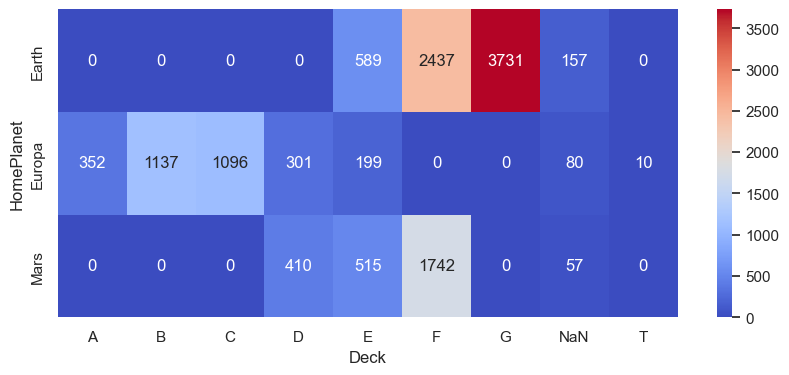

In [45]:
cabin = raw.groupby(['Deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
sns.heatmap(cabin.T, annot=True, fmt='g', cmap='coolwarm')

Выводы:
- Кабины A,B,C,T заняты пассажирами с Европы;
- Кабина G занята только пассажипами с Земли.

In [46]:
miss_val_bef = raw['HomePlanet'].isna().sum()

In [47]:
raw.loc[(raw['HomePlanet'].isna()) & (raw['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

raw.loc[(raw['HomePlanet'].isna()) & (raw['Deck'] == 'G'), 'HomePlanet'] = 'Earth'

In [48]:
print("Percentage of remaining missing values : %0.2f)" % (raw['HomePlanet'].isna().sum() / miss_val_bef * 100))

Percentage of remaining missing values : 59.87)


Посмотрим куда направлялись пассажиры с разных планет.

<AxesSubplot: xlabel='HomePlanet', ylabel='Destination'>

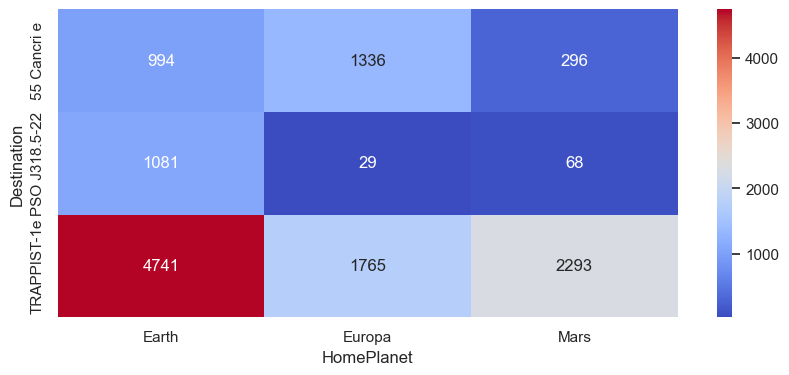

In [49]:
Destination = raw.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize=(10, 4))
sns.heatmap(Destination.T, annot=True, fmt='g', cmap='coolwarm')

Большинство прибыло с Земли и отправлялись на TRAPPIST-1e. Заполним остальные пропуски в соответсвтии с этим выводом.

In [50]:
#Учтем, что в кабинах D пассажиров с Земли не было
raw.loc[(raw['HomePlanet'].isna()) & ~(raw['Deck']=='D'), 'HomePlanet']='Earth'
raw.loc[(raw['HomePlanet'].isna()) & (raw['Deck']=='D'), 'HomePlanet']='Mars'

In [51]:
raw['HomePlanet'].isna().sum()

0

In [52]:
raw['Destination'] = raw['Destination'].fillna('TRAPPIST-1e')

Очевидно, пассажиры которые тратили деньги имеют CryoSleep False

In [53]:
raw.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [54]:
na_Cryo = raw.loc[raw['CryoSleep'].isna(), 'CryoSleep'].index
raw.loc[raw['CryoSleep'].isna(), 'CryoSleep'] = raw.groupby(['No_spending'])['CryoSleep'] \
    .transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_Cryo]

Преобразуем Bool в int

In [55]:
raw['CryoSleep'] = raw['CryoSleep'].astype(int)

Так как VIP пассажиров значительно меньше, преобразуем в int и заполним пропуски нулями.

In [58]:
raw['VIP'] = 1*(raw['VIP'])
raw['VIP'] = raw['VIP'].fillna(0)

Заменим числовые признаки медианным значением

In [59]:
for col in feats:
    raw[col]=raw[col].fillna(raw.groupby(['HomePlanet','Solo','No_spending'])[col].transform('median'))

Разобьем наших пассажиров по возрасту.


In [60]:
raw['Age_group'] = np.nan
raw.loc[raw['Age'] <= 17, 'Age_group'] = 'Age_0-17'
raw.loc[(raw['Age'] > 17) & (raw['Age'] <= 40), 'Age_group'] = 'Age_18-40'
raw.loc[raw['Age'] > 40, 'Age_group'] = 'Age_40+'

In [61]:
raw.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Cabin                   0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  294
Transported          4277
istest                  0
Group                   0
Group_size              0
Solo                    0
Deck                    0
Cabin_number            0
Cabin_side              0
Total_Expenditure       0
No_spending             0
Age_group               0
dtype: int64

# **4. Data Preprocessing**

Отбросим ненужные столбцы 

In [62]:
raw1 = raw.drop(['PassengerId', 'Name', 'Cabin', 'Cabin_number', 'Cabin_side', 'Group', 'Cabin'], axis=1)

In [304]:
train = raw1[raw1['istest'] == 0].drop(['istest'], axis=1)
test = raw1[raw1['istest'] == 1].drop(['istest', 'Transported'], axis=1)

Нормируем числовые признаки.

In [305]:
columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total_Expenditure']

for col in columns:
    train[col]=np.log(1+train[col])
    test[col]=np.log(1+test[col])

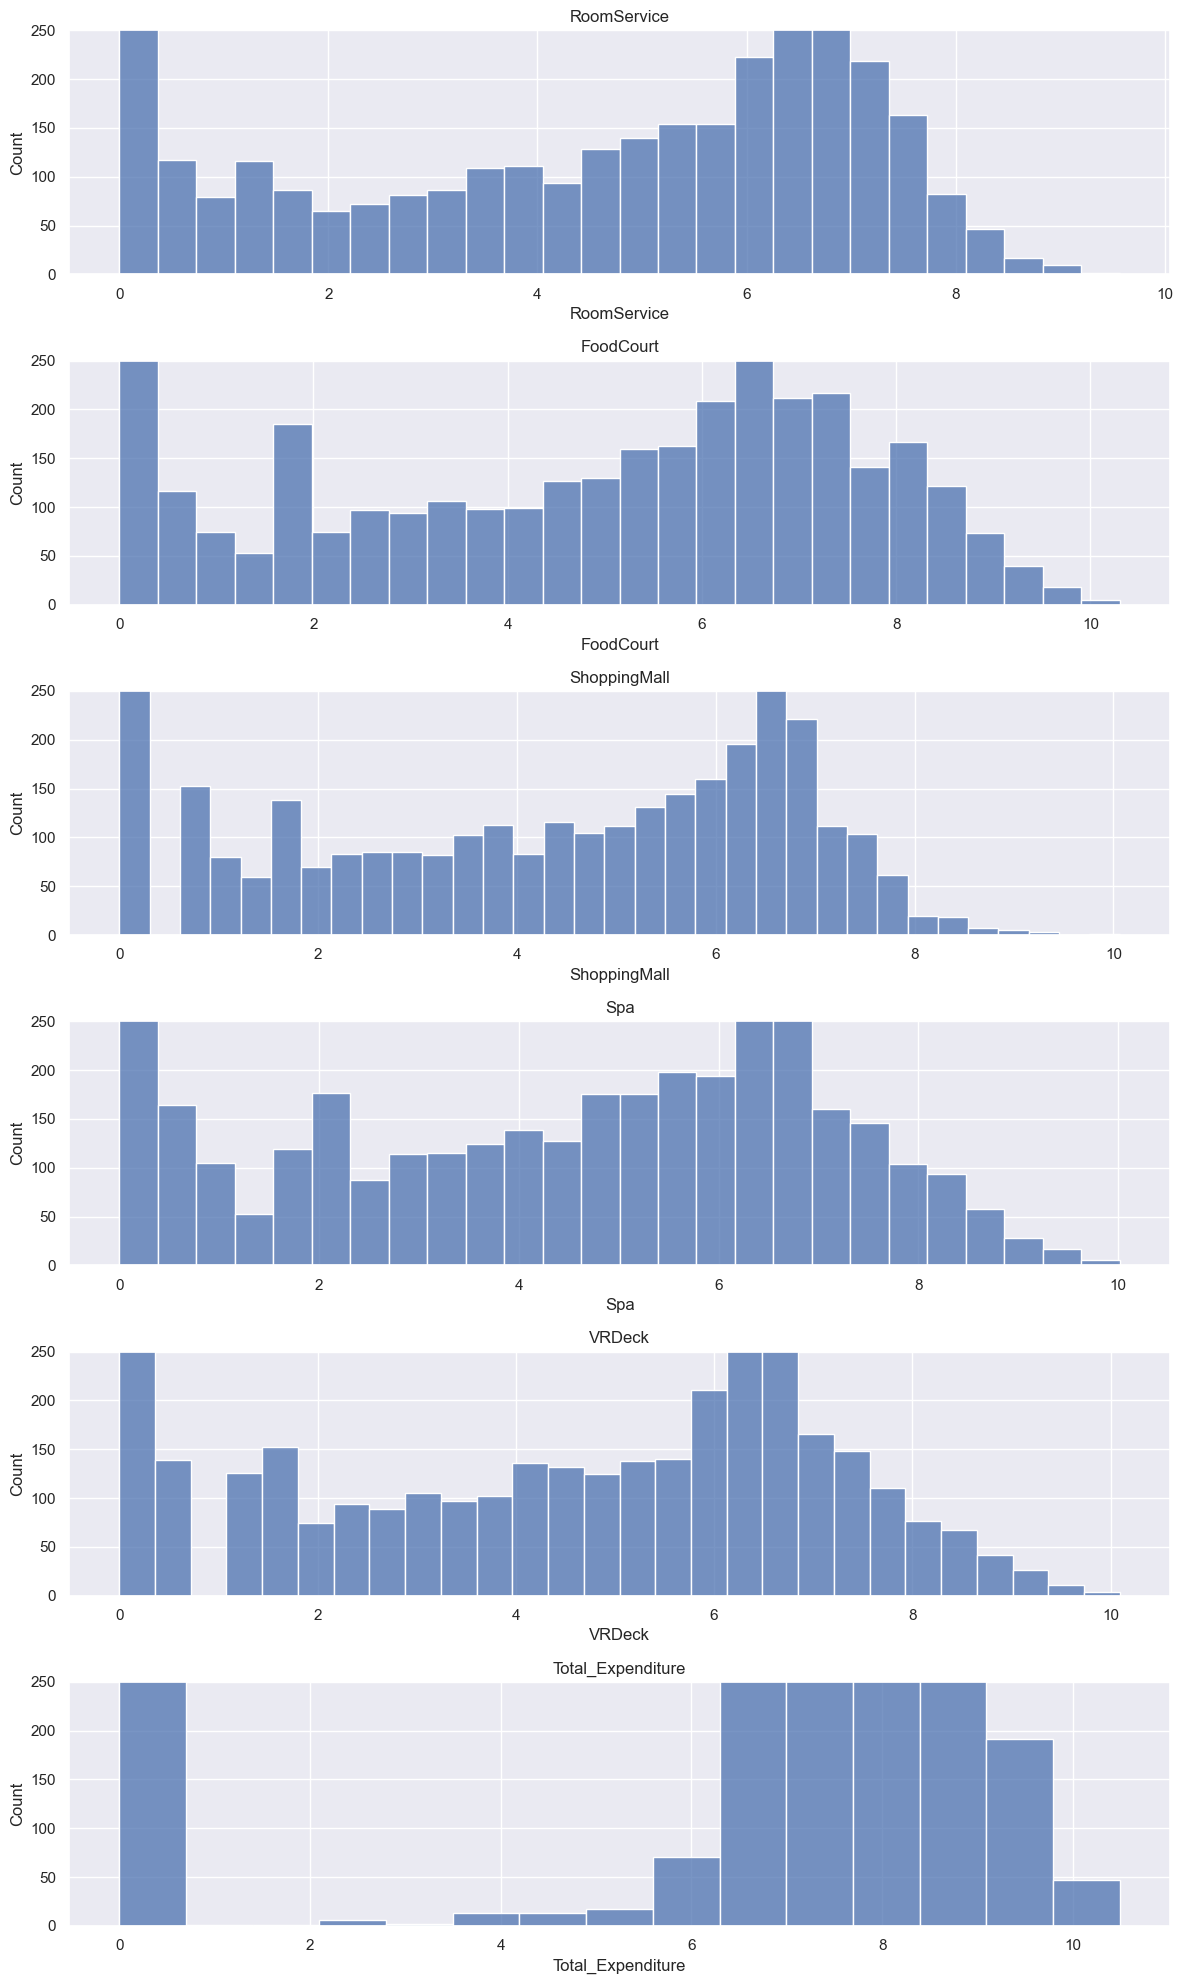

In [257]:
fig=plt.figure(figsize=(12,20))

for i, col in enumerate(columns):
    plt.subplot(6,1,1*i+1)
    sns.histplot(train[col])
    plt.ylim([0,250])
    plt.title(col)
    
fig.tight_layout()
plt.show()

In [271]:
train[[*cat_feats, 'Age_group', 'Deck']].nunique()

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
Age_group      3
Deck           9
dtype: int64

Преобразуем категориальные признаки c помощью OneHotEncoding, а Deck TargetEncoding (CryoSleep и VIP уже преобразовали до этого)

In [306]:
y = train['Transported'].copy().astype(int)
train.drop(['Transported'], axis=1, inplace=True)

In [294]:
target_encoder = train.Deck

In [295]:
encoder = ce.cat_boost.CatBoostEncoder()

In [307]:
encoder.fit(target_encoder, y)
train.Deck = encoder.transform(target_encoder)
test.Deck = encoder.transform(test.Deck)

In [76]:
def get_dummies(DataFrame, columns):
    dummies = pd.get_dummies(DataFrame[columns], drop_first=True).columns
    DataFrame[dummies] = pd.get_dummies(DataFrame[columns], drop_first=True)
    
    return DataFrame.drop(columns, axis=1)

In [308]:
train = get_dummies(train, ['HomePlanet','Destination', 'Age_group'])
test = get_dummies(test, ['HomePlanet','Destination', 'Age_group'])

Отмасштабируем наши числовые признаки

In [309]:
scaler = StandardScaler()

In [310]:
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [311]:
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, train_size=0.8, test_size=0.2, random_state=777)

# **5. Models**

In [85]:
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=777),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=777, probability=True),
    "RandomForest": RandomForestClassifier(random_state=777),
    "XGBoost": XGBClassifier(random_state=777, use_label_encoder=False, eval_metric='logloss'),
    "LGBM": LGBMClassifier(random_state=777),
    "CatBoost": CatBoostClassifier(random_state=777, verbose=False),
}

In [86]:
LR_grid = {'penalty': ['l1', 'l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
           'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "SVC": SVC_grid,
    "RandomForest": RF_grid,
    "XGBoost": boosted_grid,
    "LGBM": boosted_grid,
    "CatBoost": boosted_grid,
}

In [332]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({
    'Classifer': classifiers.keys(),
    'Validation accuracy': np.zeros(len(classifiers)),
    'Accuracy score': np.zeros(len(classifiers)),
    'F1-score': np.zeros(len(classifiers)),
    'AUC': np.zeros(len(classifiers)),
    'Training time': np.zeros(len(classifiers))
})

for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(classifier, grid[key], n_jobs=-1, cv=3)

    clf.fit(X_train, y_train)
    valid_scores.iloc[i, 1] = clf.score(X_test, y_test)

    clf_best_params[key] = clf.best_params_
    
    best_clf = clf.best_estimator_
    y_pred = best_clf.predict(X_test)
    y_pred_prob = best_clf.predict_proba(X_test)
    
    valid_scores.iloc[i, 2] = accuracy_score(y_test, y_pred)

    valid_scores.iloc[i, 3] = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    valid_scores.iloc[i, 4] = auc(fpr, tpr)

    stop = time.time()
    valid_scores.iloc[i, -1] = np.round((stop - start)/60, 2)

    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i, 2])
    print()
    i += 1

Model: LogisticRegression
Training time (mins): 0.7665324899367453

Model: KNN
Training time (mins): 0.8067855089131685

Model: SVC
Training time (mins): 0.8062104657849338

Model: RandomForest
Training time (mins): 0.8539390454284072

Model: XGBoost
Training time (mins): 0.8648648648648649

Model: LGBM
Training time (mins): 0.8326624496837263

Model: CatBoost
Training time (mins): 0.8464634847613571



In [333]:
valid_scores

,Classifer,Validation accuracy,Accuracy score,F1-score,AUC,Training time
0,LogisticRegression,0.77,0.77,0.77,0.86,0.06
1,KNN,0.81,0.81,0.80,0.90,0.03
2,SVC,0.81,0.81,0.81,0.89,1.52
3,RandomForest,0.85,0.85,0.86,0.94,0.17
4,XGBoost,0.86,0.86,0.87,0.95,0.29
5,LGBM,0.83,0.83,0.84,0.92,0.05
6,CatBoost,0.85,0.85,0.85,0.94,2.94


In [91]:
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'SVC': {'C': 1.25, 'gamma': 'auto', 'kernel': 'rbf'},
 'RandomForest': {'max_depth': 12, 'n_estimators': 200},
 'XGBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}}

In [364]:
best_models = {
    "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=777),
    "XGBoost" : XGBClassifier(**clf_best_params["XGBoost"], random_state=777),
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=777),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=777),
}

In [298]:
preds=np.zeros(len(tets))

In [367]:
FOLDS=10

for key, classifier in best_models.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=777)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(train, y)):
        # Get training and validation sets
        X_train, X_valid = train[train_idx], train[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(test)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: RandomForest
Average validation accuracy: 79.62
Training time (mins): 0.11

Model: XGBoost
Average validation accuracy: 79.77
Training time (mins): 0.03

Model: LGBM
Average validation accuracy: 80.21
Training time (mins): 0.03

Model: CatBoost
Average validation accuracy: 80.69
Training time (mins): 0.15



# **6. Submission**

Text(0.5, 0, 'Probability')

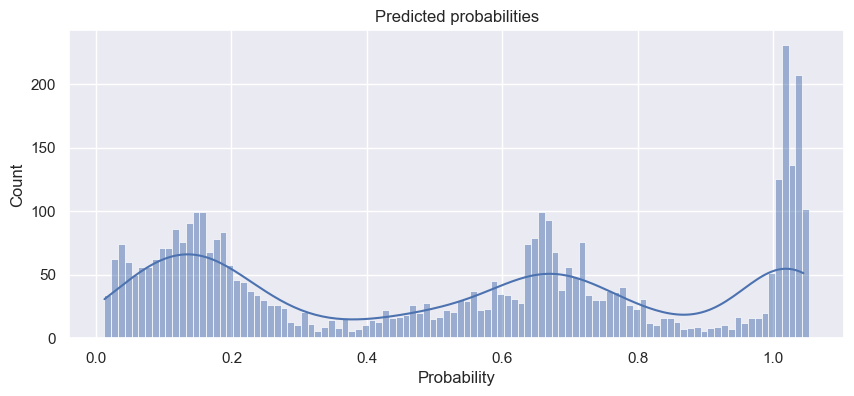

In [368]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [369]:
print(np.round(100*np.round(preds).sum()/len(preds),2))

55.13


Подгоним соотношение под то, что было в тестовой выборке.

In [379]:
print(np.round(100*np.round(preds>=0.56).sum()/len(preds),2))

51.62


In [380]:
preds_tuned=(preds>=0.56).astype(int)

In [381]:
pred = pd.read_csv('/spaceship-titanic/test.csv')

pred['Transported']=preds_tuned.astype(int)
pred=pred.replace({0:False, 1:True})

pred[['PassengerId', 'Transported']].to_csv('submission.csv', index=False)

In [345]:
pred[['PassengerId', 'Transported']]

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
5,0027_01,False
6,0029_01,False
7,0032_01,False
8,0032_02,False
9,0033_01,False
